<a href="https://colab.research.google.com/github/HRashmika/Bank_Prediction/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [5]:
file_path = 'bank-additional-full.csv'
data_add = pd.read_csv(file_path, delimiter=';')

# Debugging: print the original data
print("Original dataset shape:", data_add.shape)

# Remove duplicate rows
duplicates = data_add.duplicated().sum()
if duplicates > 0:
    print(f"\n{duplicates} duplicate rows removed.")
    data_add = data_add.drop_duplicates()
else:
    print("\nNo duplicate rows found.")

# Drop unnecessary columns
data_add = data_add.drop('duration', axis=1, errors='ignore')
data_add = data_add.drop(['default', 'pdays'], axis=1, errors='ignore')

# Handle outliers using IQR method (BEFORE normalization)
numerical_columns = data_add.select_dtypes(include=['float64', 'int64']).columns

# Exclude 'y' from numerical columns if it exists
if 'y' in numerical_columns:
    numerical_columns = numerical_columns.drop('y')

print("\nHandling Outliers Using IQR Method (Before Normalization):")
for col in numerical_columns:
    Q1 = data_add[col].quantile(0.25)  # First quartile
    Q3 = data_add[col].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data_add[(data_add[col] < lower_bound) | (data_add[col] > upper_bound)]
    print(f"Column '{col}': {len(outliers)} outliers")

    data_add[col] = np.where(data_add[col] < lower_bound, lower_bound, data_add[col])
    data_add[col] = np.where(data_add[col] > upper_bound, upper_bound, data_add[col])

print("\nOutliers handled before normalization. Dataset shape:", data_add.shape)

# Compute percentage distribution for categorical columns
categorical_columns = ['housing', 'loan', 'poutcome', 'y']

print("\nPercentage Distribution of Categories:")
for col in categorical_columns:
    print(f"\nColumn: {col}")
    percentages = data_add[col].value_counts(normalize=True) * 100
    print(percentages)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# One-hot encode categorical columns
one_hot_columns = ['job', 'marital', 'education', 'housing', 'loan',
                   'contact', 'month', 'day_of_week', 'poutcome']
data_add = pd.get_dummies(data_add, columns=one_hot_columns, drop_first=True)

# Binary encode
data_add['y'] = data_add['y'].map({'yes': 1, 'no': 0})

# Handle missing values
missing_values = data_add.isnull().sum()
if missing_values.any():
    print("\nMissing Values Found:")
    print(missing_values[missing_values > 0])
    for col in data_add.columns:
        if data_add[col].dtype == 'object':
            data_add[col].fillna('unknown', inplace=True)
        else:
            data_add[col].fillna(data_add[col].median(), inplace=True)
else:
    print("\nNo missing values found.")

# Min-Max Normalization
scaler = MinMaxScaler()
features_to_scale = data_add.drop('y', axis=1)
data_add[features_to_scale.columns] = scaler.fit_transform(features_to_scale)

# Split data into features (X) and target (y)
X = data_add.drop('y', axis=1)
y = data_add['y']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance the training dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Combine balanced data for inspection
train_data_add = pd.DataFrame(X_train_balanced, columns=X.columns)
train_data_add['y'] = y_train_balanced

test_data_add = X_test.copy()
test_data_add['y'] = y_test

# Print dataset shapes and class distributions
print("\nTraining Data Shape (After Balancing):", train_data_add.shape)
print("Testing Data Shape:", test_data_add.shape)
print("\nClass Distribution in Balanced Training Data:")
print(train_data_add['y'].value_counts(normalize=True))

# Final DataFrame Info
print("\nFinal DataFrame Info:")
data_add.info()
print("\nFinal DataFrame Preview:")
print(data_add.head())


Original dataset shape: (41188, 21)

12 duplicate rows removed.

Handling Outliers Using IQR Method (Before Normalization):
Column 'age': 468 outliers
Column 'campaign': 2406 outliers
Column 'previous': 5625 outliers
Column 'emp.var.rate': 0 outliers
Column 'cons.price.idx': 0 outliers
Column 'cons.conf.idx': 446 outliers
Column 'euribor3m': 0 outliers
Column 'nr.employed': 0 outliers

Outliers handled before normalization. Dataset shape: (41176, 18)

Percentage Distribution of Categories:

Column: housing
housing
yes        52.387313
no         45.208374
unknown     2.404313
Name: proportion, dtype: float64

Column: loan
loan
no         82.421799
yes        15.173888
unknown     2.404313
Name: proportion, dtype: float64

Column: poutcome
poutcome
nonexistent    86.339130
failure        10.326404
success         3.334467
Name: proportion, dtype: float64

Column: y
y
no     88.733728
yes    11.266272
Name: proportion, dtype: float64

No missing values found.

Training Data Shape (After 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:


# Set output directory in Google Drive
output_dir = '/content/drive/My Drive/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define file paths
transformed_path = os.path.join(output_dir, 'transformed_add.csv')
train_data_path = os.path.join(output_dir, 'train_data_add.csv')
test_data_path = os.path.join(output_dir, 'test_data_add.csv')

try:
    # Save datasets
    data_add.to_csv(transformed_path, index=False)
    train_data_add.to_csv(train_data_path, index=False)
    test_data_add.to_csv(test_data_path, index=False)

    # Confirm saved files
    if os.path.exists(transformed_path):
        print(f"Transformed data saved to: {transformed_path}")
    else:
        print("Error: Transformed data not saved.")

    if os.path.exists(train_data_path):
        print(f"Training data saved to: {train_data_path}")
    else:
        print("Error: Training data not saved.")

    if os.path.exists(test_data_path):
        print(f"Testing data saved to: {test_data_path}")
    else:
        print("Error: Testing data not saved.")
except Exception as e:
    print(f"Error while saving files: {e}")


Transformed data saved to: /content/drive/My Drive/transformed_add.csv
Training data saved to: /content/drive/My Drive/train_data_add.csv
Testing data saved to: /content/drive/My Drive/test_data_add.csv


In [24]:

# File paths for training and testing data
train_file_path = '/content/drive/My Drive/train_data_add.csv'
test_file_path = '/content/drive/My Drive/test_data_add.csv'

# Load training and testing data
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)
y_test = test_data['y']
# Modify hyperparameters manually
rf_classifier_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)

# Fit the classifier
rf_classifier_tuned.fit(X_train, y_train)

# Predict on test data
y_test_pred_tuned = rf_classifier_tuned.predict(X_test)
tuned_test_accuracy = accuracy_score(y_test, y_test_pred_tuned)

# Print tuned test accuracy
print(f"Tuned Test Accuracy: {tuned_test_accuracy:.2f}")

# Print tuned classification report
print("\nTuned Classification Report:")
print(classification_report(y_test, y_test_pred_tuned))

# Print tuned feature importances
tuned_feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_classifier_tuned.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTuned Feature Importances:")
print(tuned_feature_importances)


Tuned Test Accuracy: 0.89

Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7308
           1       0.49      0.55      0.52       928

    accuracy                           0.89      8236
   macro avg       0.72      0.74      0.73      8236
weighted avg       0.89      0.89      0.89      8236


Tuned Feature Importances:
                          Feature  Importance
6                       euribor3m    0.149407
7                     nr.employed    0.138751
1                        campaign    0.107419
3                    emp.var.rate    0.088987
33              contact_telephone    0.047961
5                   cons.conf.idx    0.047952
48               poutcome_success    0.044908
4                  cons.price.idx    0.037276
47           poutcome_nonexistent    0.033780
30                    housing_yes    0.031692
0                             age    0.030106
32                       loan_yes    

In [27]:

# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Define file paths in Google Drive
train_data_path = '/content/drive/My Drive/train_data_add.csv'
test_data_path = '/content/drive/My Drive/test_data_add.csv'

# Load the datasets
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Split features (X) and target (y)
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

# Build the Neural Network model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict classes on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7326 - loss: 0.5596 - val_accuracy: 0.5495 - val_loss: 0.7667
Epoch 2/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7731 - loss: 0.5134 - val_accuracy: 0.5714 - val_loss: 0.7358
Epoch 3/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7797 - loss: 0.4998 - val_accuracy: 0.5835 - val_loss: 0.7145
Epoch 4/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7838 - loss: 0.4896 - val_accuracy: 0.6006 - val_loss: 0.6809
Epoch 5/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7860 - loss: 0.4805 - val_accuracy: 0.6076 - val_loss: 0.6750
Epoch 6/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7884 - loss: 0.4736 - val_accuracy: 0.6167 - val_loss: 0.6657
Epoch 7/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7903 - loss: 0.4664 - val_accuracy: 0.6237 - val_loss: 0.6469
Epoch 8/30
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7920 - loss: 0.4614 - val_accurac

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Random Forest (AUC = 0.81)
Neural Network (AUC = 0.78)


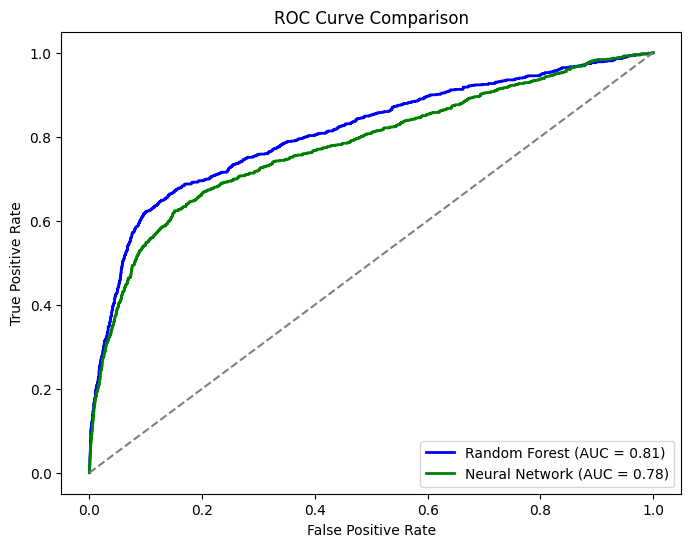

In [28]:

# Random Forest model - get predicted probabilities
rf_probs = rf_classifier.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Neural Network model - get predicted probabilities
nn_probs = model.predict(X_test).ravel()  # Flatten the output to a 1D array

# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and AUC for Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)

print(f'Random Forest (AUC = {roc_auc_rf:.2f})')
print(f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_nn, tpr_nn, color='green', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()
